# Simple Neural Network using PyTorch


The following code contains multi-class classication of MNIST Handwritten Digits data using simple Multi-Layered Perceptron (MLP). The MLP has 784 inputs in the input layer and 10 outputs in the output layer.

In [1]:
#Importing all libraries
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from collections import OrderedDict

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision.utils import make_grid
from torch.autograd import Variable

import helper

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

### Importing Dataset

In [2]:
#Import data
train_df = pd.read_csv("dataset/digit-recognizer/train.csv")
test_df = pd.read_csv("dataset/digit-recognizer/test.csv")

## Train and Validation datasets

In [3]:
#Labels(Targets) and Inputs
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

#Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, 
                                                                      train_labels,
                                                                     stratify=train_labels, 
                                                                      random_state=302,
                                                                     test_size=0.2)

## Reshaping the data to make Tensors

In [4]:
#train
train_images_tensor = torch.tensor(train_images)/255.0
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)
#val
val_images_tensor = torch.tensor(val_images)/255.0
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)
#test
test_images_tensor = torch.tensor(test_images)/255.0

## Viewing the Images

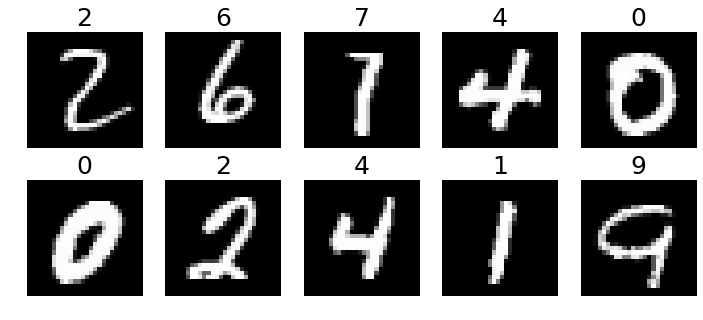

In [5]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,5000,size=10)
for i in range(10):
    axes[i].imshow(train_images[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(train_labels[idx[i]])), color= 'black', fontsize=25)
plt.show()

## Feeding them to data loader

In [6]:
#Dataloader
trainloader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)
valloader = DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)
testloader = DataLoader(test_images_tensor, batch_size=16, num_workers=2, shuffle=False)

## Defining Model Architecture

In [7]:
model = nn.Sequential(nn.Linear(784, 512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 512),
                      nn.BatchNorm1d(512),
                      nn.LeakyReLU(),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=2.0e-4 , momentum = 0.09)

## Training the model over train dataset

In [8]:
epoch = 30
valid_loss_min = np.Inf
train_losses, test_losses = [], []

for e in range(epoch):
    train_loss = 0.0
    valid_loss = 0.0
    correct = 0.0
    loss_values= []
    ################# Training ###################
    model.train()
    for images, labels in trainloader:
        #images, labels = images.to(device), labels.to(device)
        images = images.view(images.shape[0], -1)# Flatten MNIST images into 784 long vector
        optimizer.zero_grad()#Clears the gradient of optimized parameters
        output = model(images)#Forward Pass
        loss = criterion(output, labels)# Calculates the loss
        loss.backward()#Backprop
        optimizer.step()# perform a single optimization step (parameter update)
        train_loss += loss.item()*images.size(0)
        
    ############# Validation ###################
    model.eval() # prep model for evaluation
    for data, target in valloader:
        #data, labels = data.to(device), labels.to(device)
        data = data.view(data.shape[0], -1)# Flatten MNIST images into a 784 long vector
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)

    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(valloader.sampler)

    print('Epoch: {} | \tTraining Loss: {:.6f} | \tValidation Loss: {:.6f}'.format(
        e+1,train_loss,valid_loss))
    
    train_losses.append(train_loss/len(trainloader.sampler))
    test_losses.append(valid_loss/len(valloader.sampler))

    # saving model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\n | Validation loss decreased ({:.6f} --> {:.6f}) | \n'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 | 	Training Loss: 0.310622 | 	Validation Loss: 0.138475

 -----------------------Validation loss decreased (inf --> 0.138475)----------------------- 

Epoch: 2 | 	Training Loss: 0.137171 | 	Validation Loss: 0.111734

 -----------------------Validation loss decreased (0.138475 --> 0.111734)----------------------- 

Epoch: 3 | 	Training Loss: 0.088485 | 	Validation Loss: 0.084739

 -----------------------Validation loss decreased (0.111734 --> 0.084739)----------------------- 

Epoch: 4 | 	Training Loss: 0.064746 | 	Validation Loss: 0.077363

 -----------------------Validation loss decreased (0.084739 --> 0.077363)----------------------- 

Epoch: 5 | 	Training Loss: 0.048697 | 	Validation Loss: 0.076516

 -----------------------Validation loss decreased (0.077363 --> 0.076516)----------------------- 

Epoch: 6 | 	Training Loss: 0.038232 | 	Validation Loss: 0.080411
Epoch: 7 | 	Training Loss: 0.030978 | 	Validation Loss: 0.073641

 -----------------------Validation loss decreased

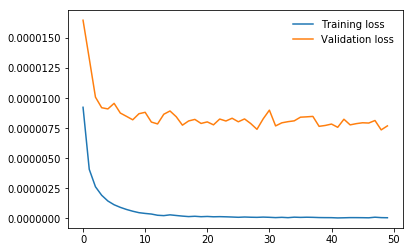

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Loading the saved model

In [10]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

## Viewing the trained data images

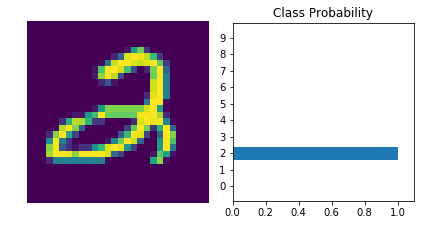

In [11]:
images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps, version="MNIST")

## Evaluation

In [12]:
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        data = data.view(data.size(0), -1)
        output = model(data)
        
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
                
    print('Accuracy: {}/{} ({:.3f}%)\n'.format(correct,\
                                                     len(data_loader.dataset),
                                                     100. * correct / len(data_loader.dataset)))

In [13]:
print("------Validation Accuracy------")
evaluate(valloader)
print("------Train Accuracy------")
evaluate(trainloader)

------Validation Accuracy------
Accuracy: 8261/8400 (98.345%)

------Train Accuracy------
Accuracy: 33600/33600 (100.000%)



## Prediction

In [14]:
def make_predictions(data_loader):
    model.eval()
    test_preds = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = data.unsqueeze(1)
        data = data.view(data.size(0), -1)
        output = model(data)
        
        preds = output.data.max(1, keepdim=True)[1]
        test_preds = torch.cat((test_preds, preds), dim=0)
        
    return test_preds


In [15]:
test_set_preds = make_predictions(testloader)
test_new = TensorDataset(test_images_tensor, test_set_preds)
testnew = DataLoader(test_new, batch_size=16, num_workers=2, shuffle=False)

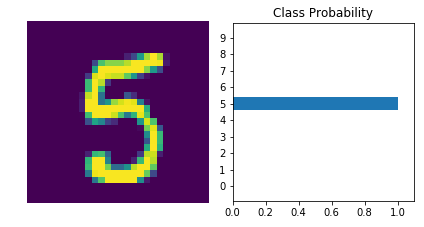

In [25]:
images, labels = next(iter(testnew))

idx = np.random.randint(0,16)
img = images[idx].view(1, 784)
# Turn off gradients to speed up this part
with torch.no_grad():
    logps = model(img)

# Output of the network are log-probabilities, need to take exponential for probabilities
ps = torch.exp(logps)
helper.view_classify(img.view(1, 28, 28), ps, version="MNIST")

## Submission

In [ ]:
sub = pd.read_csv("dataset/digit-recognizer/sample_submission.csv")
sub['Label'] = test_set_preds.numpy().squeeze()
sub.to_csv("MLP#1.csv", index=False)
#sub.head()